In [1]:
# load libraries and scripts
import JSON
using Plots
using HDF5
using Trapz
include("../scripts/tools.jl")
include("../scripts/get_grid.jl")
include("../scripts/get_params.jl")
include("../scripts/disturbances.jl")

local_disturbance (generic function with 1 method)

In [2]:
#load borders
border = import_border("../data/border.json")

# create the lattice grid
dx = 20
Nx, Ny, xrange, yrange, isinside, isborder, n = get_grid(border, Float64(dx))

# define x and y coordinate for plotting
x = repeat(reshape(xrange,1,Nx), Ny, 1)
y = repeat(reshape(yrange,Ny,1), 1, Nx);

In [3]:
# compute or load grid parameters
recompute_param = false
sigma = 100.
if(recompute_param || isfile("../numerics/grid_params_" * string(dx) * ".h5"))
    bx, by, p, m, d = get_params(isinside, isborder, sigma, Float64(dx), yrange, xrange, "../data/pantagruel.h5",
        "../numerics/grid_params_" * string(dx) * ".h5")
else
    bx, by, p, m, d = get_params(isinside, "../numerics/grid_params_" * string(dx) * ".h5")
end

([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0])

0.0


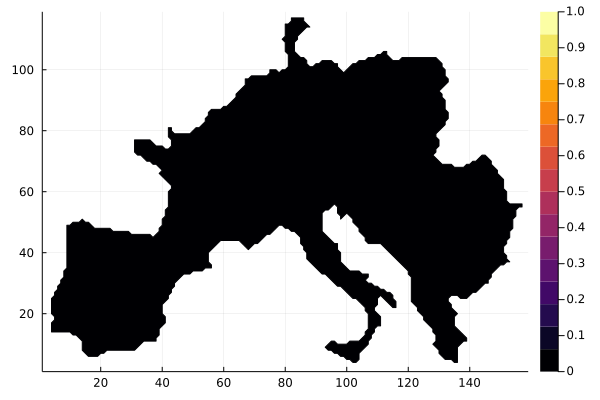

In [4]:
# define a disturbance
# dP = -9.0
dP = 0.0
sigma = 50.0
location = [-1500., -900.]
dp = local_disturbance(isinside, xrange, yrange, location, dP, sigma)
println(trapz((yrange, xrange), dp))
do_plot(isinside, dp)

In [ ]:
# perform a dynamical simulation
interval = 200
dt = 0.0001
Ndt = 100000

# println(maximum(u)*dt^2/dx^2)

gamma = 100 * d ./ m
# m = m ./10
# d = d ./10

omegas = zeros(Ny,Nx,1 + Int64(ceil(Ndt/interval)))
thetas = zeros(Ny,Nx,1 + Int64(ceil(Ndt/interval)))
th_new = zeros(Ny,Nx)
reset = true
data = h5read("../numerics/stable_" * string(dx) * ".h5", "/")
if(reset)
    th_old = copy(data["th"])
    th = copy(data["th"])
    omegas[:,:,1] = zeros(size(th))
    thetas[:,:,1] = copy(th)  
else
    omegas[:,:,1] = (th - th_old) / dt
    thetas[:,:,1] = copy(th)   
end

ts = zeros(1 + Int64(ceil(Ndt/interval)))
chi = 1 .+ gamma*dt/2

@time begin
    for t in 1:Ndt
        Threads.@threads for i in 2:Ny-1
            Threads.@threads for j in 2:Nx-1
                if(isinside[i,j])
                    bij = (by[i-1,j] + by[i,j] + bx[i,j] + bx[i,j+1])
                    th_new[i,j] = (2 - bij / m[i,j] * dt^2 / dx^2) / chi[i,j] * th[i,j] + 
                        (gamma[i,j] * dt/2 - 1) /chi[i,j] * th_old[i,j] + 
                        dt^2 / dx^2 / chi[i,j] / m[i,j] * 
                        (by[i,j] * th[i+1,j] + by[i-1,j] * th[i-1,j] +
                        bx[i,j+1] * th[i,j+1] + bx[i,j] * th[i,j-1]) +
                        dt^2 / chi[i,j] / m[i,j] * (p[i,j] + dp[i,j])
                end
            end
        end   

        # impose boundary condition
        Threads.@threads for k in 1:size(n,1)
            i = Int64(n[k,1])
            j = Int64(n[k,2])
            nx = n[k,4]
            ny = n[k,3]
            if(nx == 1)
                th_new[i,j] = th_new[i,j-2]
            elseif(nx == -1)
                th_new[i,j] = th_new[i,j+2]
            end
            if(ny == 1)
                th_new[i,j] = th_new[i-2,j]
            elseif(ny == -1)
                th_new[i,j] = th_new[i+2,j]
            end
        end
        
        if(mod(t,interval) == 0)
            println("NIter: ", t)
            omegas[:,:,Int64(t/interval) + 1] = (th_new-th) / dt
            thetas[:,:,Int64(t/interval) + 1] = th_new
            ts[Int64(t/interval) + 1] = t*dt
        end
        th_old = copy(th)
        th = copy(th_new)
    end
end

NIter: 200
NIter: 400
NIter: 600
NIter: 800
NIter: 1000
NIter: 1200
NIter: 1400
NIter: 1600
NIter: 1800
NIter: 2000
NIter: 2200
NIter: 2400
NIter: 2600
NIter: 2800
NIter: 3000
NIter: 3200
NIter: 3400
NIter: 3600
NIter: 3800
NIter: 4000
NIter: 4200
NIter: 4400
NIter: 4600
NIter: 4800
NIter: 5000
NIter: 5200
NIter: 5400
NIter: 5600
NIter: 5800
NIter: 6000
NIter: 6200
NIter: 6400
NIter: 6600
NIter: 6800
NIter: 7000
NIter: 7200
NIter: 7400
NIter: 7600
NIter: 7800
NIter: 8000
NIter: 8200
NIter: 8400
NIter: 8600
NIter: 8800
NIter: 9000
NIter: 9200
NIter: 9400
NIter: 9600
NIter: 9800
NIter: 10000
NIter: 10200
NIter: 10400
NIter: 10600
NIter: 10800
NIter: 11000
NIter: 11200
NIter: 11400
NIter: 11600
NIter: 11800
NIter: 12000
NIter: 12200
NIter: 12400
NIter: 12600
NIter: 12800
NIter: 13000
NIter: 13200
NIter: 13400
NIter: 13600
NIter: 13800
NIter: 14000
NIter: 14200
NIter: 14400
NIter: 14600
NIter: 14800
NIter: 15000
NIter: 15200
NIter: 15400
NIter: 15600
NIter: 15800
NIter: 16000
NIter: 16200


In [ ]:
@gif for i=1:size(omegas,3)
    do_plot(isinside, omegas[:,:,i])
    #contour(omegas[:,:,i],fill=true,levels= -2:0.1:2)
    #contour(omegas[:,:,i],fill=true)
end

In [ ]:
start=1
plot(omegas[20,20,start:end])
plot!(omegas[60,80,start:end])
plot!(omegas[10,100,start:end])
plot!(omegas[24,121,start:end])

In [ ]:
do_plot(isinside, th)